# Analysis of Union College math major student data

## Part 4 - Preliminary hypothesis testing

General notes on interpretation:
* In short, these results are still preliminary, data exploration.
<br><br>
* **Effect size** and **confidence interval** provide an estimate of the magnitude and precision of an observed difference between groups
  + **Cohen's d** measures the magnitude of the difference between two means in units of standard deviations.
  + The **probability of superiority** (aka. the common language effect size) gives the probability that a randomly selected member of one group has a greater score than a randomly selected member of another group.
<br><br>
* The **p-value** serves as a guideline for significance; however: 
  + Using a significance cutoff of 0.05 still has 1 in 20 chance of a false positive
  + Any non-statistically significant results are best considered as inconclusive rather than as no effect (especially when the p-value or the power is relatively low)
<br><br>
* Post hoc **power analysis** informs on the number of samples needed to reject a false null hypothesis, however;
  + Here, it is based on the observed effect size, and so if the confidence interval spans a wide range, the power also has potentially large error.
<br><br>
* Since this setting is not experimental we cannot infer causation
  + Alternative plausible explanations for results should be considered

## Set up the notebook environment

In [1]:
# Imports
from IPython.display import HTML 
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.stats.api as sms
#from statsmodels.stats.power import TTestIndPower
import union_constants as uc

In [2]:
# Settings
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (6.0, 6.0)
pd.set_option('max_rows', 7)
pd.set_option('max_columns', 50)

In [3]:
# Load data - cleaned in part 1
cleaned_data_fn = 'data/union_students_818_cleaned.xlsx'
info = pd.read_excel(cleaned_data_fn, sheet_name='info')
grades = pd.read_excel(cleaned_data_fn, sheet_name='grades')

### GPA by group analyses



In [4]:
def compare_groups(g1_dist, g2_dist, g1_label='group1', g2_label='group2',
                   percent_ci=95, power=0.80, alpha=0.05):
    
    '''Calculate and display various statistics comparing two independent groups
    
       Required parameters:
         g1_dist, g2_dist: groups as pandas series objects
         
       Optional parameters:
         g1_label, g2_label: group names for printing
         percent_ci: confidence level for interval determination as a percent
         power and alpha: post-hoc sample size estimation
         
       Returns: None    
     '''
    
    # Descriptive statistics
    g1_stats = g1_dist.agg(['count', 'mean', 'std'])
    g2_stats = g2_dist.agg(['count', 'mean', 'std'])

    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(pd.DataFrame([g1_stats[['mean', 'std']],
                              g2_stats[['mean', 'std']]],
                             index=[g1_label, g2_label]))
    
    print('  Difference in means = {0:.2f}'
          .format(g1_stats['mean'] - g2_stats['mean']))
    
    # Confidence interval
    cm = sms.CompareMeans(sms.DescrStatsW(g1_dist),
                          sms.DescrStatsW(g2_dist))
    ci = cm.tconfint_diff(1 - (percent_ci / 100), usevar='unequal')
    print('  {0:.0f}% confidence interval = ({1:.2f}, {2:.2f})\n'
          .format(percent_ci, ci[0], ci[1]))

    # Effect size
    print('Effect size:')
    s_pooled = np.sqrt((((g1_stats['count'] - 1) * g1_stats['std'] ** 2) +
                        ((g2_stats['count'] - 1) * g2_stats['std'] ** 2)) /
                       (g1_stats['count'] + g2_stats['count'] - 2))

    cohen_d = np.abs(g1_stats['mean'] - g2_stats['mean']) / s_pooled
    print("  Cohen's d = {0:.2f}".format(cohen_d))
    
    common_lang = stats.norm.cdf((g1_stats['mean'] - g2_stats['mean']) / 
                               np.sqrt(g1_stats['std'] ** 2 + 
                                       g2_stats['std'] ** 2))

    print('  Probability of superiority = {0:.1f}%\n'.format(common_lang * 100))

    # Signifiance
    _, p_value = stats.ttest_ind(g1_dist, g2_dist, equal_var=False)

    print('Signifiance:')
    print('  P-value = {0:.4f}\n'.format(p_value))


    # Power Analysis
    ratio = g2_stats['count'] / g1_stats['count']
    analysis = sms.TTestIndPower()
    g1_min_obs = analysis.solve_power(cohen_d, None, alpha, power, ratio=ratio)
    eq_min_obs = analysis.solve_power(cohen_d, None, alpha, power, ratio=1)
    
    print('Sample size power analysis:')
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(pd.DataFrame([[g1_stats['count'], g1_min_obs, eq_min_obs], 
                              [g2_stats['count'], g1_min_obs * ratio, 
                               eq_min_obs]],
                             index=[g1_label, g2_label],
                             columns=['original sample size', 
                                      'min size (same ratio)',
                                      'min size (equal size)']))
    print('    (minimum sample size for power = {0:.2f} and signifiance = '
          '{1:.2f} at observed effect size)'.format(power, alpha))

#### MTH-110 and  MTH-112 vs MTH-113

Comparing the two common intro course paths (MTH-110 and MTH-112 against MTH-113).
* Students in MTH-110 and MTH-112 tended to be awarded higher grades than students in MTH-113.
  + The effect is not statistically significant at a 0.05 cutoff, but is relatively low (p-values 0.08 and 0.14) considering the small sample size may be worth additional investigation 
  + The effect size is low to moderate
  + See part 3 notebook for grade point distribution graphs
* Students overall GPA was not significantly affected by whether they took MTH-110 or MTH-113

In [5]:
# MTH-110 vs MTH-113 grade point comparison
print('\033[1m' + 'Grade point by course (MTH-110 vs MTH-113):')
compare_groups(grades.loc[grades['course'] == 'MTH-110'].point,
               grades.loc[grades['course'] == 'MTH-113'].point,
              'MTH-110', 'MTH-113')

print('\n')
# MTH-112 vs MTH-113 grade point comparison
print('\033[1m' + 'Grade point by course (MTH-112 vs MTH-113):')
compare_groups(grades.loc[grades['course'] == 'MTH-112'].point,
               grades.loc[grades['course'] == 'MTH-113'].point,
              'MTH-112', 'MTH-113')

Grade point by course (MTH-110 vs MTH-113):


,mean,std
MTH-110,3.66,0.45
MTH-113,3.43,0.59


  Difference in means = 0.23
  95% confidence interval = (-0.03, 0.49)

Effect size:
  Cohen's d = 0.44
  Probability of superiority = 62.2%

Signifiance:
  P-value = 0.0801

Sample size power analysis:


,original sample size,min size (same ratio),min size (equal size)
MTH-110,29,77,84
MTH-113,35,92,84


    (minimum sample size for power = 0.80 and signifiance = 0.05 at observed effect size)


Grade point by course (MTH-112 vs MTH-113):


,mean,std
MTH-112,3.63,0.49
MTH-113,3.43,0.59


  Difference in means = 0.20
  95% confidence interval = (-0.07, 0.47)

Effect size:
  Cohen's d = 0.37
  Probability of superiority = 60.3%

Signifiance:
  P-value = 0.1441

Sample size power analysis:


,original sample size,min size (same ratio),min size (equal size)
MTH-112,28,106,117
MTH-113,35,132,117


    (minimum sample size for power = 0.80 and signifiance = 0.05 at observed effect size)


In [6]:
print('\033[1m' + 'Overall GPA (students who took MTH-110 vs MTH-113):')

took_110_gpa = info.loc[info.id.isin(grades.loc[grades.course == 'MTH-110']
                                 .id.values)].gpa
took_113_gpa = info.loc[info.id.isin(grades.loc[grades.course == 'MTH-113']
                                 .id.values)].gpa

with pd.option_context('display.float_format', '{:,.3f}'.format):
    display(pd.DataFrame([took_110_gpa.agg(['mean', 'std']),
                          took_113_gpa.agg(['mean', 'std'])],
                         index=['took 110', 'took 113']))

Overall GPA (students who took MTH-110 vs MTH-113):


,mean,std
took 110,3.078,0.569
took 113,3.083,0.557


#### Intro courses vs. no intro courses

Comparing overall GPA of students who took any intro course to those who took none.
* Students who took no intro courses far outperformed those who did
  + The effect is large and statistically significant
  + Almost certainly this relates to their aptitude identified by placement tests
    * The aspect I find interesting is that placement in MTH-110 vs MTH-113 appears nearly irrelevant to GPA (above), while testing out of all intro courses has a large effect 

In [7]:
# Took intro courses (Yes / No) GPA comparison
courses_intro = uc.courses_intro + ['MTH-100', 'MTH-101', 'MTH-102']

took_intro = info.loc[info.id.isin(grades
                                   .loc[grades.course.isin(courses_intro)]
                                   .id.values)].gpa

no_intro = info.loc[~info.id.isin(grades
                                   .loc[grades.course.isin(courses_intro)]
                                   .id.values)].gpa

print('\033[1m' + 'GPA by students who took / did not take intro courses:')
compare_groups(no_intro, took_intro, 'No intro', 'Took intro') 

GPA by students who took / did not take intro courses:


,mean,std
No intro,3.54,0.53
Took intro,3.10,0.56


  Difference in means = 0.44
  95% confidence interval = (0.23, 0.64)

Effect size:
  Cohen's d = 0.80
  Probability of superiority = 71.6%

Signifiance:
  P-value = 0.0001

Sample size power analysis:


,original sample size,min size (same ratio),min size (equal size)
No intro,46,22,25
Took intro,64,30,25


    (minimum sample size for power = 0.80 and signifiance = 0.05 at observed effect size)


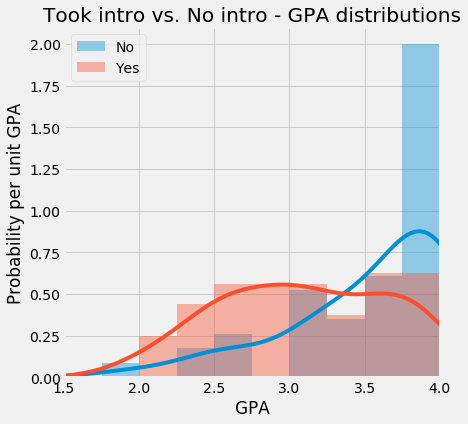

In [8]:
# Took intro courses (yes vs. no) distributions 
bins = np.arange(1, 4.1, 0.25)
sns.distplot(no_intro, bins=bins, label='No')
sns.distplot(took_intro, bins=bins, label='Yes')
plt.xlim(1.5, 4)
plt.legend()
plt.ylabel('Probability per unit GPA')
plt.xlabel('GPA')
plt.title('Took intro vs. No intro - GPA distributions')
plt.show()

#### Single vs. multiple major

Comparing GPAs of students who had a single major vs. multiple majors
* Students with multiple majors outperformed those with a single major
  + Appears to be dominated by large number of multi majors earning > 3.75 GPA, while the rest of the distributions are more similar
  + The effect was statistical significant and of moderate size
  + There are many possible explanations for this
    * Course difficulty, material overlap, aptitude, etc.
  + It would be interesting to look at across different multi-majors, but sample size too small.

In [9]:
# Single vs multipe major (Yes / No) GPA comparison
single_gpa = info.loc[info.major == 'MT'].gpa
multi_gpa = info.loc[info.major != 'MT'].gpa

print('\033[1m' + 'GPA by students with single vs. multiple majors')
compare_groups(multi_gpa, single_gpa, 'Multiple', 'Single') 

GPA by students with single vs. multiple majors


,mean,std
Multiple,3.41,0.58
Single,3.13,0.56


  Difference in means = 0.28
  95% confidence interval = (0.06, 0.50)

Effect size:
  Cohen's d = 0.49
  Probability of superiority = 63.6%

Signifiance:
  P-value = 0.0116

Sample size power analysis:


,original sample size,min size (same ratio),min size (equal size)
Multiple,62,75,66
Single,48,58,66


    (minimum sample size for power = 0.80 and signifiance = 0.05 at observed effect size)


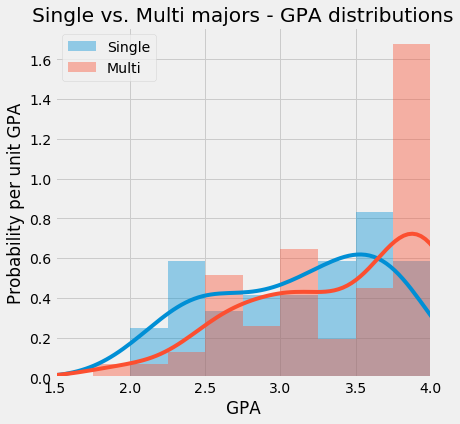

In [10]:
# Single vs multiple major distributions 
bins = np.arange(1, 4.1, 0.25)
sns.distplot(single_gpa, bins=bins, label='Single')
sns.distplot(multi_gpa, bins=bins, label='Multi')
plt.xlim(1.5, 4)
plt.legend()
plt.ylabel('Probability per unit GPA')
plt.xlabel('GPA')
plt.title('Single vs. Multi majors - GPA distributions')
plt.show()

#### Greek Affiliation

Comparing GPAs of students who had a Greek affiliation against those how did not.
* Students without a Greek affiliation had slightly better GPAs, however;
  + The effect was not statistical significant 
  + The effect was relatively small
  + A much larger sample size (~ 4x) would be require to detect an effect of this size with sufficient power

In [11]:
# Greek Affiliation (Yes / No) GPA comparison
print('\033[1m' + 'GPA by Greek affiliation:')
compare_groups(info.loc[info.greek.isnull()].gpa, 
               info.loc[info.greek.notnull()].gpa,
               'Not Greek affiliated', 'Greek affiliated')

GPA by Greek affiliation:


,mean,std
Not Greek affiliated,3.35,0.57
Greek affiliated,3.19,0.59


  Difference in means = 0.16
  95% confidence interval = (-0.06, 0.39)

Effect size:
  Cohen's d = 0.28
  Probability of superiority = 57.9%

Signifiance:
  P-value = 0.1545

Sample size power analysis:


,original sample size,min size (same ratio),min size (equal size)
Not Greek affiliated,66,248,199
Greek affiliated,44,166,199


    (minimum sample size for power = 0.80 and signifiance = 0.05 at observed effect size)


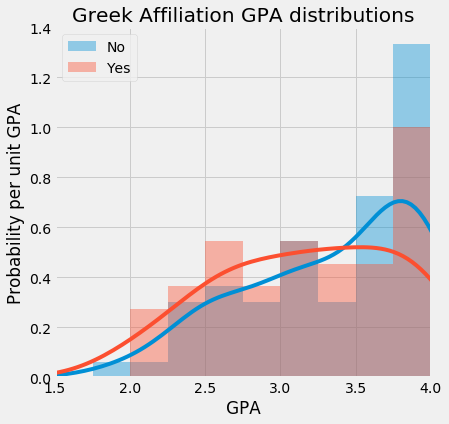

In [12]:
# Greek affiliation (yes vs. no) distributions 
bins = np.arange(1, 4.1, 0.25)
ax = sns.distplot(info.loc[info.greek.isnull()].gpa, bins=bins, label='No')
sns.distplot(info.loc[info.greek.notnull()].gpa, bins=bins, label='Yes')
plt.xlim(1.5, 4)
plt.legend()
plt.ylabel('Probability per unit GPA')
plt.xlabel('GPA')
plt.title('Greek Affiliation GPA distributions')
plt.show()

#### Steinmetz Symposium

Comparing GPAs of students who expressed vs. did not express interest in Steinmetz Symposium 
* Students who expressed interest had slightly better GPAs, however;
  + The effect was not statistical significant 
  + The effect was relatively small
  + A much larger sample size (~ 6x) would be require to detect an effect of this size with sufficient power

In [13]:
# Steinmetz Symposium interest (Yes / No) GPA comparison
stein_gpa = info.loc[(info.loc[:, 'interest_1':'interest_6'] == 
                              'Steinmetz Symposium').T.any()].gpa
no_stein_gpa = info.loc[~(info.loc[:, 'interest_1':'interest_6'] == 
                              'Steinmetz Symposium').T.any()].gpa

print('\033[1m' + 'GPA by students who expressed / did not express interest in '
      'Steinmetz Symposium:')
compare_groups(stein_gpa, no_stein_gpa, 'Interest', 'No interest') 

GPA by students who expressed / did not express interest in Steinmetz Symposium:


,mean,std
Interest,3.35,0.56
No interest,3.22,0.60


  Difference in means = 0.13
  95% confidence interval = (-0.09, 0.35)

Effect size:
  Cohen's d = 0.22
  Probability of superiority = 56.1%

Signifiance:
  P-value = 0.2567

Sample size power analysis:


,original sample size,min size (same ratio),min size (equal size)
Interest,54,328,334
No interest,56,340,334


    (minimum sample size for power = 0.80 and signifiance = 0.05 at observed effect size)


### Grade point correlations

* Some pairs of courses were infrequently taken by the same students
  + Calculating correlations for course pairs that occur at least 20 times
  + Course pairs with fewer than 20 observations were not calculated left blank in the heat map
<br><br>
* Many strong correlations were observed
  + Not surprising that past performance is indicative of future performance
  + Though individual students performance may change course to course
<br><br>  
* Some correlations are much stronger than others
  + Planning to determine confidence intervals to better judge how much of this is dues to noise 
  + Possibly some is due to courses with tighter grade distributions have less chance to be correlated
  + Possibly courses with more in common are more highly correlated
<br><br>
* No negative correlations were observed
  + Also not surprising, but might have been interesting

In [14]:
# Highest correlations
min_count = 20
min_periods = 20

corr_data = (grades
             .groupby('course')
             .filter(lambda group: len(group) >= min_count)
             .pivot_table('point', 'id', 'course', aggfunc='mean')
             .corr(min_periods=min_periods)
             .stack()
             .reset_index(level=1) 
             .rename({'course':'course_2', 0:'correlation'}, axis=1)
             .reset_index(level=0) 
             .rename({'course':'course_1'}, axis=1)
            )

print('Highest course pair grade point correlations:')

with pd.option_context('max_row', None,
                       'display.float_format', '{:,.2f}'.format):
    display(HTML(corr_data[(corr_data.course_1 < corr_data.course_2) & 
                      (corr_data.correlation > 0.7)]
                 .sort_values('correlation', ascending=False)
                 .to_html(index=False)))    


Highest course pair grade point correlations:


course_1,course_2,correlation
MTH-199,MTH-235,0.83
MTH-219,MTH-234,0.81
MTH-332,MTH-336,0.80
MTH-117,MTH-235,0.79
MTH-219,MTH-332,0.79
MTH-219,MTH-336,0.78
MTH-235,MTH-340,0.78
MTH-264,MTH-332,0.75
MTH-115H,MTH-340,0.73
MTH-199,MTH-264,0.72


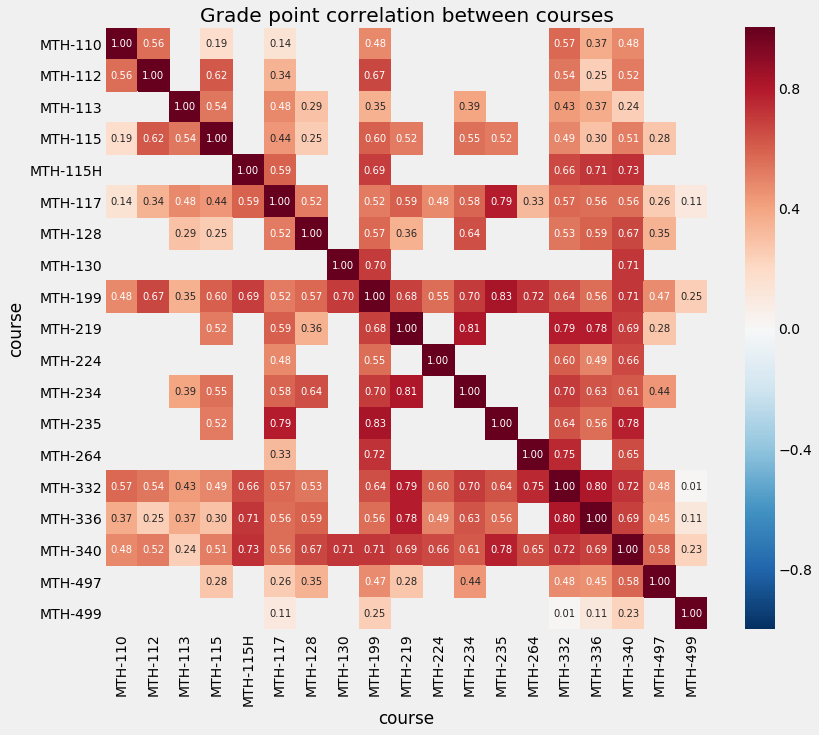

In [15]:
# Grade point correlation by course
min_count = 20    # exclude courses taken less than min_count times
min_periods = 20  # don't calculate correlation for course combinations 
                  # occuring less than min_periods

graph_data = (grades
              .groupby('course')
              .filter(lambda group: len(group) >= min_count)
              .pivot_table('point', 'id', 'course', aggfunc='mean')
              .corr(min_periods=min_periods)
             )

fig = plt.figure(figsize=(12, 12))
ax = (sns.heatmap(graph_data, 
                  vmin=-1, vmax=1, center=0,
                  cmap='RdBu_r', cbar_kws={'shrink':0.86},
                  annot=True, fmt='.2f', annot_kws={'fontsize':10},
                  square=True
                )
     )

plt.title('Grade point correlation between courses')
plt.show()

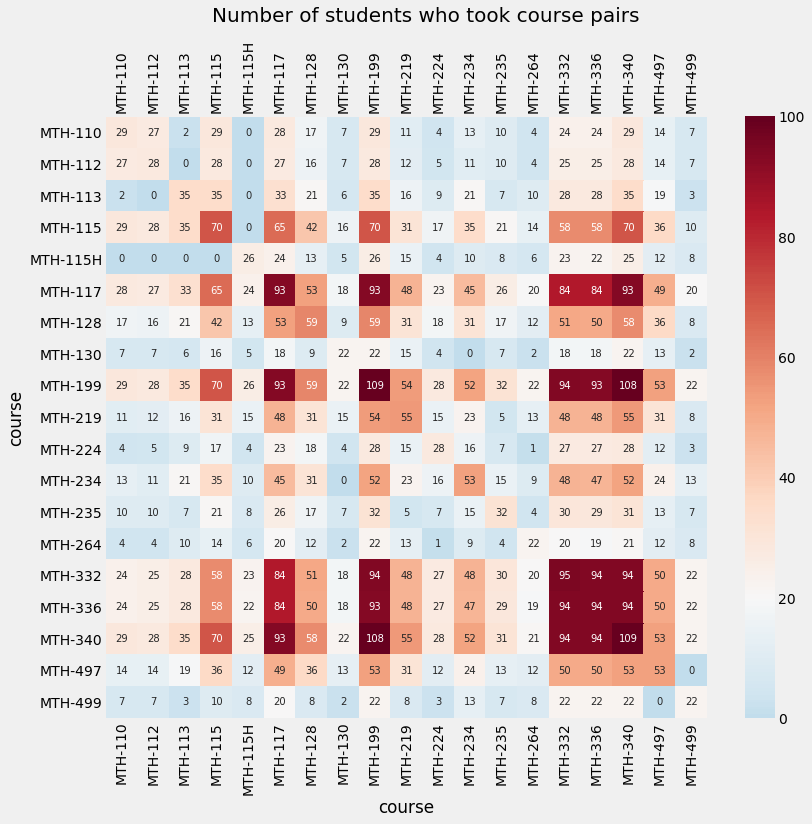

In [16]:
# Counts of times course pairs were taken by the same student
min_count = 20
corr_data = (grades
             .groupby('course')
             .filter(lambda group: len(group) >= min_count)
             .pivot_table('point', 'id', 'course', aggfunc='max')
            )

pair_count = np.zeros((corr_data.shape[1], corr_data.shape[1]))
for index, row in pd.notnull(corr_data).iterrows():
    for i in range(len(row)):
        for j in range(i, len(row)):
            pair_count[i, j] += (int(row[i] and row[j]))
            if i != j:
                pair_count[j, i] += (int(row[i] and row[j]))

fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(pd.DataFrame(pair_count, index=corr_data.columns, 
                         columns=corr_data.columns),
                  cmap='RdBu_r', cbar_kws={'shrink':0.86},
                  vmin=0, vmax=100, center=20,
                  annot=True, fmt='.0f', annot_kws={'fontsize':10},
                  square=True
           )

ax.xaxis.set_tick_params(labeltop=True)
plt.xticks(rotation=90)
plt.suptitle('Number of students who took course pairs',  
             y=0.95, x=0.45, fontsize=20)
plt.show()

To Do: Confidence intervals for correlation

    Wikipedia article actually looks useful
    https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Using_the_Fisher_transformation


    mean = artanh(r)

    SE = 1 / sqrt(n - 3)

    tanh(artanh - z_alpha_2 SE), tanh(artanh + z_alpha_2 SE)

    i.e. r 0.3, n=50, tanh(0.30952 ± 1.96/√47),  (0.024, 0.534)

